In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, RegressorMixin, clone
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sales-forecasting/sample_submission.csv
/kaggle/input/sales-forecasting/train.csv
/kaggle/input/sales-forecasting/test.csv
/kaggle/input/sales-forecasting/EconomicIndicators.csv


In [2]:
# Load the given datasets
economic_indicators_df = pd.read_csv('/kaggle/input/sales-forecasting/EconomicIndicators.csv')
test_df = pd.read_csv('/kaggle/input/sales-forecasting/test.csv')
train_df = pd.read_csv('/kaggle/input/sales-forecasting/train.csv')

Extract the first five rows of the datasets to get an idea on the columns and merging

In [3]:
economic_indicators_df.head()

,Month,Consumer Sentiment,Interest Rate,PMI,Money Supply,NationalEAI,EastEAI,WestEAI,SouthEAI,NorthEAI
0,1,67.2,1.538500,55.5,20847.8,57.083078,56.512247,54.628506,56.512247,57.083078
1,2,62.8,1.811579,57.3,20964.3,47.496553,45.454201,47.021588,45.454201,47.496553
2,3,59.4,2.109130,58.8,21115.6,41.697385,39.904398,42.656425,41.280411,41.697385
3,4,65.2,2.777500,59.2,21315.8,48.503429,46.417782,46.417782,48.018395,43.653086
4,5,58.4,2.874286,57.0,21549.3,41.535949,38.379217,39.749903,42.491276,49.843138


In [4]:
test_df.head()

,ID,Company,Quarter,QuickRatio,InventoryRatio,RevenueGrowth,MarketshareChange,Bond rating,Stock rating,Region,Industry
0,7,CMP01,Q8,1.93,2.79,-0.03,-0.01,CCC,Buy,South,Metal Fabrication
1,8,CMP01,Q9,1.93,4.77,0.00,0.00,CCC,Buy,South,Metal Fabrication
2,16,CMP02,Q8,1.97,2.34,0.04,-0.03,A,Sell,West,Infrastructure
3,17,CMP02,Q9,1.93,4.14,0.04,0.01,BBB,Hold,West,Infrastructure
4,25,CMP03,Q8,0.67,NaN,-0.05,-0.01,BB,Buy,East,Infrastructure


In [5]:
train_df.head()

,ID,Company,Quarter,QuickRatio,InventoryRatio,RevenueGrowth,MarketshareChange,Bond rating,Stock rating,Region,Industry,Sales
0,0,CMP01,Q1,2.02,7.71,0.05,-0.04,CCC,Buy,South,Metal Fabrication,1517.0
1,1,CMP01,Q2,2.01,4.10,0.03,0.00,CCC,Hold,South,Metal Fabrication,2968.0
2,2,CMP01,Q3,2.02,6.79,0.06,-0.02,CCC,Buy,South,Metal Fabrication,1497.0
3,3,CMP01,Q4,1.98,3.97,0.01,0.02,CCC,Buy,South,Metal Fabrication,2929.0
4,4,CMP01,Q5,1.96,7.41,-0.07,0.02,CCC,Buy,South,Metal Fabrication,1452.0


**Data Merging**

The months in the train and test data must me grouped into quarters w.r.t economic indicators dataset for merging

In [6]:
# Define a function to map month to quarter
def month_to_quarter(month):
    if month in range(1, 4):
        return 'Q1'
    elif month in range(4, 7):
        return 'Q2'
    elif month in range(7, 10):
        return 'Q3'
    elif month in range(10, 13):
        return 'Q4'
    elif month in range(13, 16):
        return 'Q5'
    elif month in range(16, 19):
        return 'Q6'
    elif month in range(19, 22):
        return 'Q7'
    elif month in range(22, 25):
        return 'Q8'
    elif month in range(25, 29):
        return 'Q9'
    else:
        return None

In [7]:
# Apply the mapping function to create 'Quarter' column in economic_indicators_df
economic_indicators_df['Quarter'] = economic_indicators_df['Month'].apply(month_to_quarter)

In [8]:
# Merge economic indicators with train and test data
train_merged = pd.merge(train_df,economic_indicators_df, how='inner', left_on='Quarter', right_on='Quarter')
test_merged = pd.merge(test_df, economic_indicators_df, how='inner', left_on='Quarter', right_on='Quarter')

In [9]:
train_merged.head()

,ID,Company,Quarter,QuickRatio,InventoryRatio,RevenueGrowth,MarketshareChange,Bond rating,Stock rating,Region,...,Month,Consumer Sentiment,Interest Rate,PMI,Money Supply,NationalEAI,EastEAI,WestEAI,SouthEAI,NorthEAI
0,0,CMP01,Q1,2.02,7.71,0.05,-0.04,CCC,Buy,South,...,1,67.2,1.538500,55.5,20847.8,57.083078,56.512247,54.628506,56.512247,57.083078
1,0,CMP01,Q1,2.02,7.71,0.05,-0.04,CCC,Buy,South,...,2,62.8,1.811579,57.3,20964.3,47.496553,45.454201,47.021588,45.454201,47.496553
2,0,CMP01,Q1,2.02,7.71,0.05,-0.04,CCC,Buy,South,...,3,59.4,2.109130,58.8,21115.6,41.697385,39.904398,42.656425,41.280411,41.697385
3,1,CMP01,Q2,2.01,4.10,0.03,0.00,CCC,Hold,South,...,4,65.2,2.777500,59.2,21315.8,48.503429,46.417782,46.417782,48.018395,43.653086
4,1,CMP01,Q2,2.01,4.10,0.03,0.00,CCC,Hold,South,...,5,58.4,2.874286,57.0,21549.3,41.535949,38.379217,39.749903,42.491276,49.843138


In [10]:
test_merged.head()

,ID,Company,Quarter,QuickRatio,InventoryRatio,RevenueGrowth,MarketshareChange,Bond rating,Stock rating,Region,...,Month,Consumer Sentiment,Interest Rate,PMI,Money Supply,NationalEAI,EastEAI,WestEAI,SouthEAI,NorthEAI
0,7,CMP01,Q8,1.93,2.79,-0.03,-0.01,CCC,Buy,South,...,22,63.8,4.772381,50.0,20820.7,48.358393,46.278982,47.874809,47.874809,43.522553
1,7,CMP01,Q8,1.93,2.79,-0.03,-0.01,CCC,Buy,South,...,23,61.3,4.486190,49.4,20854.5,48.781545,45.074147,46.683938,49.903520,48.781545
2,7,CMP01,Q8,1.93,2.79,-0.03,-0.01,CCC,Buy,South,...,24,69.7,4.004500,48.2,20863.7,64.515048,61.740901,65.998894,65.998894,77.418057
3,8,CMP01,Q9,1.93,4.77,0.00,0.00,CCC,Buy,South,...,25,71.7,4.058120,47.7,20825.5,63.372042,62.738322,60.647044,60.647044,63.372042
4,8,CMP01,Q9,1.93,4.77,0.00,0.00,CCC,Buy,South,...,26,67.4,3.958333,50.4,20755.3,57.615784,55.138305,57.039626,57.039626,57.615784


Check and remove any outliers if present

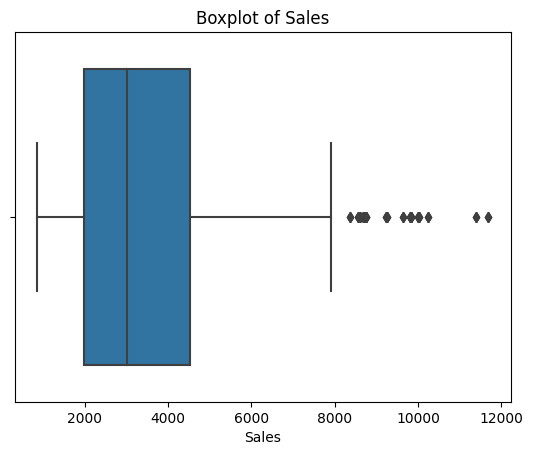

In [11]:
# Determine any outliers in the target variable (Sales)
sns.boxplot(x=train_merged['Sales'])
plt.title('Boxplot of Sales')
plt.show()

In [12]:
# Handle the outliers
# Set a threshold for outliers and remove them
outlier_threshold = 1.5
Q1 = train_merged['Sales'].quantile(0.25)
Q3 = train_merged['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - outlier_threshold * IQR
upper_bound = Q3 + outlier_threshold * IQR

In [13]:
train_merged = train_merged[(train_merged['Sales'] >= lower_bound) & (train_merged['Sales'] <= upper_bound)]

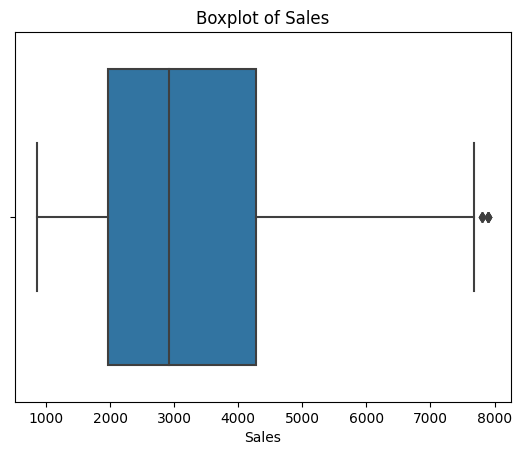

In [14]:
sns.boxplot(x=train_merged['Sales'])
plt.title('Boxplot of Sales')
plt.show()

Checking the data types of the merged train and test datasets

In [15]:
train_merged.dtypes

ID                      int64
Company                object
Quarter                object
QuickRatio            float64
InventoryRatio        float64
RevenueGrowth         float64
MarketshareChange     float64
Bond rating            object
Stock rating           object
Region                 object
Industry               object
Sales                 float64
Month                   int64
Consumer Sentiment    float64
Interest Rate         float64
PMI                   float64
Money Supply          float64
NationalEAI           float64
EastEAI               float64
WestEAI               float64
SouthEAI              float64
NorthEAI              float64
dtype: object

In [16]:
test_merged.dtypes

ID                      int64
Company                object
Quarter                object
QuickRatio            float64
InventoryRatio        float64
RevenueGrowth         float64
MarketshareChange     float64
Bond rating            object
Stock rating           object
Region                 object
Industry               object
Month                   int64
Consumer Sentiment    float64
Interest Rate         float64
PMI                   float64
Money Supply          float64
NationalEAI           float64
EastEAI               float64
WestEAI               float64
SouthEAI              float64
NorthEAI              float64
dtype: object

In [17]:
# Combine the training and test data
combined_data = pd.concat([train_merged, test_merged], ignore_index=True)

To make predictions on a model, we need to convert the categorical data types to numerical data types

In [18]:
# Convert the categorical datatypes to numerical data types
# Encode categorical features
categorical_cols = ['Quarter', 'Company','Bond rating', 'Stock rating', 'Region', 'Industry']
combined_dummies = pd.get_dummies(combined_data, columns=categorical_cols)

In [19]:
# Split the combined data back into train and test
train_data = combined_dummies[combined_dummies['ID'].isin(train_merged['ID'])]
test_data = combined_dummies[combined_dummies['ID'].isin(test_merged['ID'])]

In [20]:
# Align the columns
common_cols = set(train_data.columns) & set(test_data.columns)
train_data = train_data[list(common_cols)]
test_data = test_data[list(common_cols)]

In [21]:
# Check if there are any null values
train_data.isnull().sum()

Company_CMP17              0
Company_CMP67              0
Industry_Infrastructure    0
Company_CMP58              0
Company_CMP25              0
                          ..
Company_CMP05              0
Company_CMP52              0
Company_CMP42              0
Region_West                0
Company_CMP70              0
Length: 119, dtype: int64

In [22]:
test_data.isnull().sum()

Company_CMP17              0
Company_CMP67              0
Industry_Infrastructure    0
Company_CMP58              0
Company_CMP25              0
                          ..
Company_CMP05              0
Company_CMP52              0
Company_CMP42              0
Region_West                0
Company_CMP70              0
Length: 119, dtype: int64

In [23]:
train_data = train_data.fillna(train_data.median())
test_data = test_data.fillna(test_data.median())

In [24]:
# Split the data into features and target variable
X_train = train_data.drop('Sales', axis = 1)
y_train = train_data['Sales']
X_test = test_data.drop('Sales', axis = 1)

In [25]:
X_train.shape

(1515, 118)

In [26]:
X_test.shape

(525, 118)

In [27]:
#Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
#Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

In [29]:
# Initialize and train the model (XGBRegressor)
Model = XGBRegressor(objective='reg:squarederror')  # 'reg:squarederror' for regression tasks
grid_search = GridSearchCV(Model, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [30]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300}


In [31]:
# Create and train XGBoost Regressor with best hyperparameters
Model = XGBRegressor(objective='reg:squarederror', **best_params)
Model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# Train other regression models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [33]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
# Stacking
class StackingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.trained_models = [clone(m) for m in self.models]
        for model in self.trained_models:
            model.fit(X, y)
        return self

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.trained_models])
        return np.mean(predictions, axis=1)

In [35]:
stacking_reg = StackingRegressor([Model, lin_reg, rf_reg])
stacking_reg.fit(X_train, y_train)

StackingRegressor(models=[XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=0.2, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=7,
                                       max_leaves=None, min_child_weight=1,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=300,
                                       n_jobs=None, num_parallel_tree=None,
                                       random_state=None, ...),
                          LinearRegression(),
                          RandomForestRegressor(random_state=42)])

In [36]:
# Make Predictions on the training set
train_prediction = stacking_reg.predict(X_train)

In [37]:
train_prediction

array([4470.90090118, 2300.1550827 , 2613.38534524, ..., 4269.72176331,
       5868.86674885, 3064.79528911])

In [38]:
# Training set MAE
train_mae = mean_absolute_error(y_train, train_prediction)
print(f'Training MAE: {train_mae}')

Training MAE: 231.15240385562439


In [39]:
# Make Predictions on the validation set
Valid_prediction = stacking_reg.predict(X_val)

In [40]:
Valid_prediction

array([5402.42061209, 2330.09786881, 5902.78171594, 1930.49689259,
       1949.96208646, 2336.01753154, 3315.41134158, 1832.23439586,
       5911.92818122, 1629.07051093, 3643.94170316, 5257.01249958,
       4942.26392887, 2253.18551306, 5254.61784798, 2215.48706404,
       4688.62191737, 3154.82963474, 2948.993214  , 3628.74025886,
       3231.542096  , 3062.37780328, 2124.05260162, 1075.51449588,
       1562.69050148, 2675.48599109, 3705.93391748, 2618.70705349,
       2115.96461639, 2387.51006461, 3999.6580918 , 2244.6173215 ,
       1793.93022066, 1808.19623175, 1924.46072868, 2093.2132564 ,
       3388.96294008, 3622.27886075, 2526.7101578 , 2118.45621892,
       3941.26992747, 2472.29793583, 2403.73005794, 4175.14970325,
       3795.02395431, 4907.70181672, 4910.73685969, 3309.50990228,
       2388.1307529 , 4342.20574821, 2594.04452416, 4696.37521808,
       1716.23300473, 5708.86095329, 5019.59499891, 5162.22683807,
       2510.64630777, 1989.11220192, 2240.94139815, 4031.28730

In [41]:
# Validation set MAE
valid_mae = mean_absolute_error(y_val, Valid_prediction)
print(f'Validation MAE: {valid_mae}')

Validation MAE: 310.54754737807957


In [42]:
# Make Predictions on the test data
test_prediction = stacking_reg.predict(X_test)

In [43]:
test_prediction

array([2317.54228999, 2318.50865636, 2229.64129119, 2054.4779924 ,
       2049.34671532, 2028.71241233, 2045.41952868, 5158.86904886,
       5195.56156106, 5165.03046542, 4224.85389171, 4222.04530342,
       4197.74900011, 4236.60194979, 5366.19682104, 5360.7938645 ,
       5329.78537953, 5449.89495074, 5437.6199497 , 5411.43143935,
       5400.65720805, 3320.12278294, 3280.15982965, 3342.29830433,
       2813.79694301, 2814.36711449, 2782.38462953, 2809.71841256,
       5563.30962614, 5559.81237924, 5519.40241641, 5611.25236503,
       5630.06871165, 5594.30570911, 5609.5282877 , 3974.03777901,
       3938.77455879, 3937.21407513, 3906.83952027, 3907.13004332,
       3888.05014299, 3902.59059268, 4264.45256813, 4261.43157773,
       4221.04738964, 3649.32793154, 3662.02293375, 3638.70300413,
       3679.72278325, 1935.86065568, 1925.96982967, 1899.5819518 ,
       2338.69289929, 2347.04290476, 2322.43736967, 2333.72415725,
       2569.32512274, 2570.39337714, 2531.93369426, 2403.45015

In [44]:
submission_df = pd.DataFrame({'ID': test_merged['ID'], 'Sales': (test_prediction)})
submission_df

,ID,Sales
0,7,2317.542290
1,7,2318.508656
2,7,2229.641291
3,8,2054.477992
4,8,2049.346715
...,...,...
520,673,2062.350611
521,674,1963.937718
522,674,1982.034350
523,674,1947.336038


In [45]:
#submission_final = submission_df['Sales'].groupby(submission_df['ID'])
grouped_df = submission_df.groupby('ID').mean()

In [46]:
grouped_df.reset_index(inplace=True)
grouped_df

,ID,Sales
0,7,2288.564079
1,8,2044.489162
2,16,5173.153692
3,17,4220.312536
4,25,5352.258688
...,...,...
145,656,5594.737574
146,664,2949.856558
147,665,3371.282227
148,673,2096.474379


In [47]:
grouped_df.to_csv('submission.csv', index=False)